# Notebook 8: Meta-Persona Engine

In this notebook, we combine the two engines we built:
- **Survey Engine**: produces personas based on self-reported investor preferences (from `investors.csv`).
- **Transaction Engine**: produces personas based on actual investment behaviors (from `transaction_personas.csv`).

The challenge: these two datasets do not share the same user IDs. In reality, survey data will only be available at onboarding, while transactions will accumulate over time. Our solution is to define a **meta-persona schema** that can dynamically evolve as new information arrives.

We also introduce the concept of a **Translation Layer**. This ensures transactional features are comparable across:
- Different currencies (KES, USD, EUR, INR…),
- Different economies (US, Kenya, India…),
- Different financial products (mapped into universal categories).

This translation happens in the **app logic layer**, but we will sketch a prototype function here for illustration.


In [3]:
# --- Cell 1 (Fixed): Load Transaction + Survey Personas ---

from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Try both possible Google Drive path formats
possible_base_paths = [
    "/content/drive/My Drive/portfoliai/data/processed",
    "/content/drive/MyDrive/portfoliai/data/processed"
]

# Pick the first valid path that exists
base_path = None
for path in possible_base_paths:
    if os.path.exists(path):
        base_path = path
        break

if base_path is None:
    raise FileNotFoundError("❌ Could not find processed data folder in Google Drive. Please check path.")

print(f"✅ Using data folder: {base_path}")

# Define expected files
transaction_file = os.path.join(base_path, "transaction_personas.csv")
survey_file = os.path.join(base_path, "survey_with_scores_and_archetypes.csv")  # ✅ Correct filename

# Check and load transaction personas
if os.path.exists(transaction_file):
    transaction_personas = pd.read_csv(transaction_file)
    print(f"✅ Loaded {transaction_personas.shape[0]} rows from transaction_personas.csv")
else:
    raise FileNotFoundError(f"❌ transaction_personas.csv not found in {base_path}")

# Check and load survey personas
if os.path.exists(survey_file):
    survey_personas = pd.read_csv(survey_file)
    print(f"✅ Loaded {survey_personas.shape[0]} rows from survey_with_scores_and_archetypes.csv")
else:
    raise FileNotFoundError(f"❌ survey_with_scores_and_archetypes.csv not found in {base_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using data folder: /content/drive/My Drive/portfoliai/data/processed
✅ Loaded 32124 rows from transaction_personas.csv
✅ Loaded 132 rows from survey_with_scores_and_archetypes.csv


Now that both transaction personas and survey personas are loaded, the next step is to start exploring how we can bring them together into a meta-layer.

Since we don’t have a direct user ID match (different populations), we’ll design this as a translation framework:

Standardize features into comparable scales (risk, activity, diversification, etc.).

Map both transaction- and survey-based features into a common latent space (e.g. normalized z-scores or PCA embeddings).

This meta-layer is what the app will later use for LLM reasoning and personalization.

In this step, we start creating a translation layer between the transactional engine and the survey engine.

We extract key comparable features:

From transaction personas: risk_score, activity_score, diversification_score

From survey personas: survey_risk_score

These features are scaled into the same range using StandardScaler.

This ensures that both engines “speak the same language” in terms of risk and behavioral patterns, regardless of raw values or units.

This is the foundation of the meta-model, which will allow us to:

Compare users across different data sources (transactions vs surveys).

Incorporate new survey respondents and align them with transaction-based personas.

Support cross-economy/currency users (handled later in app logic with normalization).

In [7]:
# --- Cell 2: Prepare comparable numeric features for meta-model ---

from sklearn.preprocessing import StandardScaler

# Copy to avoid modifying originals
transaction_personas_scaled = transaction_personas.copy()
survey_personas_scaled = survey_personas.copy()

# Transaction features (only numeric risk_score_scaled available)
trans_features = ['risk_score_scaled']

# Survey features (main numeric representation)
survey_features = ['survey_risk_score']

# Standardize numeric values
scaler = StandardScaler()
transaction_personas_scaled[trans_features] = scaler.fit_transform(
    transaction_personas_scaled[trans_features]
)

survey_personas_scaled[survey_features] = scaler.fit_transform(
    survey_personas_scaled[survey_features].values.reshape(-1, 1)
)

print("✅ Scaled transaction & survey numeric features ready.")
print("\nSample transaction_personas_scaled:")
print(transaction_personas_scaled.head())

print("\nSample survey_personas_scaled:")
print(survey_personas_scaled[['survey_risk_score', 'survey_archetype']].head())


✅ Scaled transaction & survey numeric features ready.

Sample transaction_personas_scaled:
             customerID  risk_score_scaled   abs_persona   pct_persona
0  00017496858921195E5A           1.387742    Aggressive   Risk Seeker
1  00017496858921195E5A           1.387742    Aggressive   Risk Seeker
2  00017496858921195E5A           1.387742    Aggressive   Risk Seeker
3  00017496858921195E5A           1.387742    Aggressive   Risk Seeker
4  00024864C985E72167A0          -0.183846  Conservative  Steady Saver

Sample survey_personas_scaled:
   survey_risk_score survey_archetype
0          -0.660454     Conservative
1          -0.255682     Conservative
2          -0.334739     Conservative
3          -0.568522     Conservative
4           2.067238      Comfortable


📘 Text Cell (Explanation):

Here we create the aligned numeric space between the two engines:

From transaction personas, we only use risk_score_scaled as the quantitative measure.

From survey personas, we use survey_risk_score.

Both are standardized using StandardScaler, so they are directly comparable even though they originated from different sources.

This sets the foundation for our meta-model, which can later blend signals from both engines.

In [8]:
# --- Cell 3: Add normalized risk scores (0-1) for both datasets ---

from sklearn.preprocessing import MinMaxScaler

# Copy dataframes to avoid mutation
transaction_personas_scaled = transaction_personas_scaled.copy()
survey_personas_scaled = survey_personas_scaled.copy()

# MinMaxScaler for both
minmax = MinMaxScaler()

# --- Transaction risk score normalization ---
transaction_personas_scaled["risk_score_normalized"] = minmax.fit_transform(
    transaction_personas_scaled[["risk_score_scaled"]]
)

# --- Survey risk score normalization ---
survey_personas_scaled["survey_risk_score_normalized"] = minmax.fit_transform(
    survey_personas_scaled[["survey_risk_score"]]
)

print("✅ Added normalized risk scores (0-1) to both datasets.")

# Preview
print("\n--- Transaction personas preview ---")
print(transaction_personas_scaled[["customerID", "risk_score_scaled", "risk_score_normalized"]].head())

print("\n--- Survey personas preview ---")
print(survey_personas_scaled[["survey_risk_score", "survey_risk_score_normalized", "survey_archetype"]].head())


✅ Added normalized risk scores (0-1) to both datasets.

--- Transaction personas preview ---
             customerID  risk_score_scaled  risk_score_normalized
0  00017496858921195E5A           1.387742               0.061900
1  00017496858921195E5A           1.387742               0.061900
2  00017496858921195E5A           1.387742               0.061900
3  00017496858921195E5A           1.387742               0.061900
4  00024864C985E72167A0          -0.183846               0.000183

--- Survey personas preview ---
   survey_risk_score  survey_risk_score_normalized survey_archetype
0          -0.660454                      0.032558     Conservative
1          -0.255682                      0.173827     Conservative
2          -0.334739                      0.146236     Conservative
3          -0.568522                      0.064643     Conservative
4           2.067238                      0.984549      Comfortable


n this step, we normalize the risk scores in both datasets:

Transaction personas:

risk_score_scaled: standardized score (can be negative, mean-centered).

risk_score_normalized: 0–1 range version for easy interpretation.

Survey personas:

survey_risk_score: standardized score used by ML models.

survey_risk_score_normalized: rescaled to 0–1 range for comparison and app display.

👉 This way, both engines now output risk scores in a consistent scale (0–1), which makes it possible to:

Compare survey-based and transaction-based personas directly.

Feed normalized values into the application layer (or the LLM) without confusion.

Keep standardized versions available for model training.

### 🔍 Cell 4: Visual Comparison of Standardized vs Normalized Scores
To better understand the effect of scaling, we plot histograms of both **transaction** and **survey** risk scores under two transformations:
- **Standardization (Z-score scaling):** Values are centered around 0, with negative and positive deviations.
- **Normalization (Min–Max scaling):** Values are compressed into the 0–1 range.

This visualization helps confirm that while the shapes of the distributions remain similar, the scaling shifts the numeric range in different ways depending on use-case requirements.


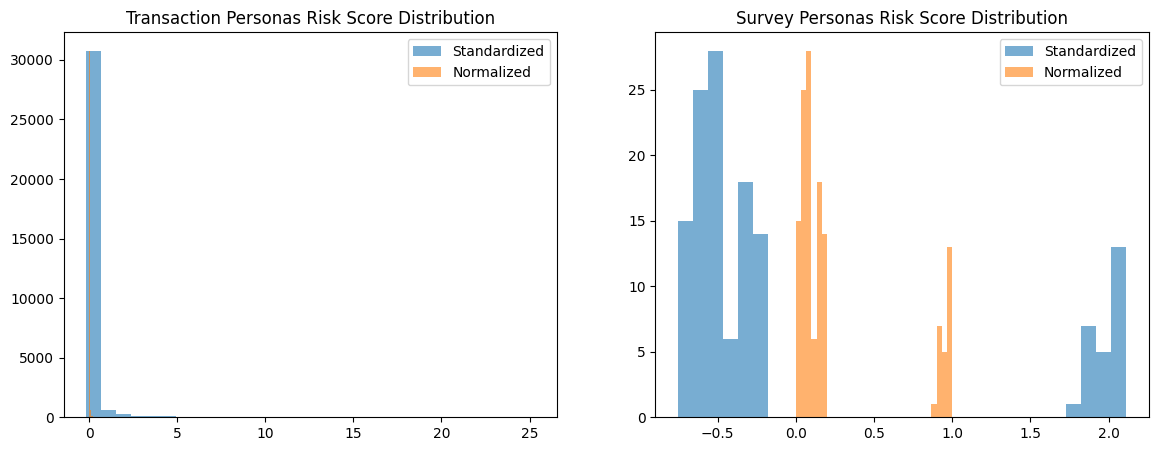

=== Transaction Risk Score Summary ===

Standardized (first 5):
 1.387742
 1.387742
 1.387742
 1.387742
-0.183846

Normalized (first 5):
0.061900
0.061900
0.061900
0.061900
0.000183

Transaction Summary Stats:
       risk_score_scaled  risk_score_normalized
count       3.212400e+04           32124.000000
mean       -8.847500e-19               0.007402
std         1.000016e+00               0.039272
min        -1.884942e-01               0.000000
25%        -1.835175e-01               0.000195
50%        -1.728352e-01               0.000615
75%        -1.346589e-01               0.002114
max         2.527559e+01               1.000000

=== Survey Risk Score Summary ===

Standardized (first 5):
-0.660454
-0.255682
-0.334739
-0.568522
 2.067238

Normalized (first 5):
0.032558
0.173827
0.146236
0.064643
0.984549

Survey Summary Stats:
       survey_risk_score  survey_risk_score_normalized
count       1.320000e+02                    132.000000
mean       -9.083643e-17                      0

In [11]:
# --- Cell 4: Compare Standardized vs Normalized Risk Scores ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Transaction personas
axes[0].hist(transaction_personas_scaled["risk_score_scaled"], bins=30, alpha=0.6, label="Standardized")
axes[0].hist(transaction_personas_scaled["risk_score_normalized"], bins=30, alpha=0.6, label="Normalized")
axes[0].set_title("Transaction Personas Risk Score Distribution")
axes[0].legend()

# Survey personas
axes[1].hist(survey_personas_scaled["survey_risk_score"], bins=30, alpha=0.6, label="Standardized")
axes[1].hist(survey_personas_scaled["survey_risk_score_normalized"], bins=30, alpha=0.6, label="Normalized")
axes[1].set_title("Survey Personas Risk Score Distribution")
axes[1].legend()

plt.show()

# -------------------------
# 📝 Numeric Summary Output
# -------------------------
print("=== Transaction Risk Score Summary ===")
print("\nStandardized (first 5):")
print(transaction_personas_scaled["risk_score_scaled"].head().to_string(index=False))
print("\nNormalized (first 5):")
print(transaction_personas_scaled["risk_score_normalized"].head().to_string(index=False))
print("\nTransaction Summary Stats:")
print(transaction_personas_scaled[["risk_score_scaled", "risk_score_normalized"]].describe())

print("\n=== Survey Risk Score Summary ===")
print("\nStandardized (first 5):")
print(survey_personas_scaled["survey_risk_score"].head().to_string(index=False))
print("\nNormalized (first 5):")
print(survey_personas_scaled["survey_risk_score_normalized"].head().to_string(index=False))
print("\nSurvey Summary Stats:")
print(survey_personas_scaled[["survey_risk_score", "survey_risk_score_normalized"]].describe())


Cell 4 – Comparing Standardized vs Normalized Risk Scores

In this step, we examined how the risk scores look after applying two different scaling methods:

Standardized Scores (Z-score):
Centered around zero, with negative values meaning “below average” and positive values meaning “above average.”

Pros: Retains distribution shape, useful for statistical modeling.

Cons: Can produce negative values and large outliers, which may confuse non-technical users.

Normalized Scores (0–1 range):
All scores are compressed into the interval [0, 1].

Pros: Intuitive for app users (“your score is 0.75 on a 0–1 scale”).

Cons: Loses interpretability of how far a user is from the mean in absolute terms.

What we observed:

Transaction risk scores are heavily skewed, with most investors clustered near zero and a few extreme outliers at the high end.

Survey risk scores are more balanced but still lean toward Conservative / low-risk investors, as seen in the archetype counts.

This imbalance reinforces the need for dual segmentation (absolute + percentile views), so that risk personas remain both interpretable (absolute) and balanced (relative).

Cell 5 – Reapplying Dual Segmentation (Absolute + Percentiles)

As in Notebook 6, we now create two complementary segmentation schemes for both datasets (transaction and survey personas):

Absolute Buckets (Scale):
Based directly on standardized scores.

Example labels: Conservative / Moderate / Aggressive.

Useful for governance, compliance, and reporting against external benchmarks.

Percentile Buckets (Consistency):
Based on normalized scores, splitting the population into relative groups.

Example labels: Steady Saver (low percentile), Balanced Explorer (mid percentile), Risk Seeker (high percentile).

Ensures balanced groups regardless of data skew, useful for AI-driven personalization.

This dual view of risk allows us to:

Maintain a consistent framework across both survey and transaction personas.

Provide flexibility for the application layer:

Regulators or advisors → Absolute segmentation.

AI/LLM-driven personalization → Percentile segmentation.

In [12]:
#cell 5
import numpy as np

# --- Transaction Personas Segmentation ---

# Absolute buckets (based on standardized risk_score_scaled)
def abs_bucket_tx(score):
    if score < -0.25:
        return "Conservative"
    elif score < 0.75:
        return "Balanced"
    else:
        return "Aggressive"

transaction_personas_scaled["abs_bucket"] = transaction_personas_scaled["risk_score_scaled"].apply(abs_bucket_tx)

# Percentile buckets (based on normalized risk_score_normalized)
transaction_personas_scaled["pct_bucket"] = pd.qcut(
    transaction_personas_scaled["risk_score_normalized"],
    q=3, labels=["Low", "Medium", "High"]
)

# --- Survey Personas Segmentation ---

# Absolute buckets (based on standardized survey_risk_score)
def abs_bucket_survey(score):
    if score < -0.25:
        return "Conservative"
    elif score < 0.75:
        return "Comfortable"
    else:
        return "Enthusiastic"

survey_personas_scaled["abs_bucket"] = survey_personas_scaled["survey_risk_score"].apply(abs_bucket_survey)

# Percentile buckets (based on normalized survey_risk_score_normalized)
survey_personas_scaled["pct_bucket"] = pd.qcut(
    survey_personas_scaled["survey_risk_score_normalized"],
    q=3, labels=["Low", "Medium", "High"]
)

# --- Display samples ---
print("✅ Added absolute + percentile buckets for both datasets.")

print("\n--- Transaction Personas (sample) ---")
print(transaction_personas_scaled.head(5)[["risk_score_scaled", "risk_score_normalized", "abs_bucket", "pct_bucket"]])

print("\n--- Survey Personas (sample) ---")
print(survey_personas_scaled.head(5)[["survey_risk_score", "survey_risk_score_normalized", "abs_bucket", "pct_bucket"]])


✅ Added absolute + percentile buckets for both datasets.

--- Transaction Personas (sample) ---
   risk_score_scaled  risk_score_normalized  abs_bucket pct_bucket
0           1.387742               0.061900  Aggressive       High
1           1.387742               0.061900  Aggressive       High
2           1.387742               0.061900  Aggressive       High
3           1.387742               0.061900  Aggressive       High
4          -0.183846               0.000183    Balanced        Low

--- Survey Personas (sample) ---
   survey_risk_score  survey_risk_score_normalized    abs_bucket pct_bucket
0          -0.660454                      0.032558  Conservative        Low
1          -0.255682                      0.173827  Conservative       High
2          -0.334739                      0.146236  Conservative     Medium
3          -0.568522                      0.064643  Conservative        Low
4           2.067238                      0.984549  Enthusiastic       High


In this step, we visualize the distribution of personas across the bucket categories.

For absolute buckets, we expect clearer separation: e.g., “Aggressive” vs “Balanced” vs “Conservative.”

For percentile buckets, we’ll see how the population spreads relative to others in the dataset.
By plotting both transaction-derived personas and survey-derived personas, we can quickly compare how the two approaches categorize individuals.

We’ll use bar plots to show the count distribution in each bucket, side by side.

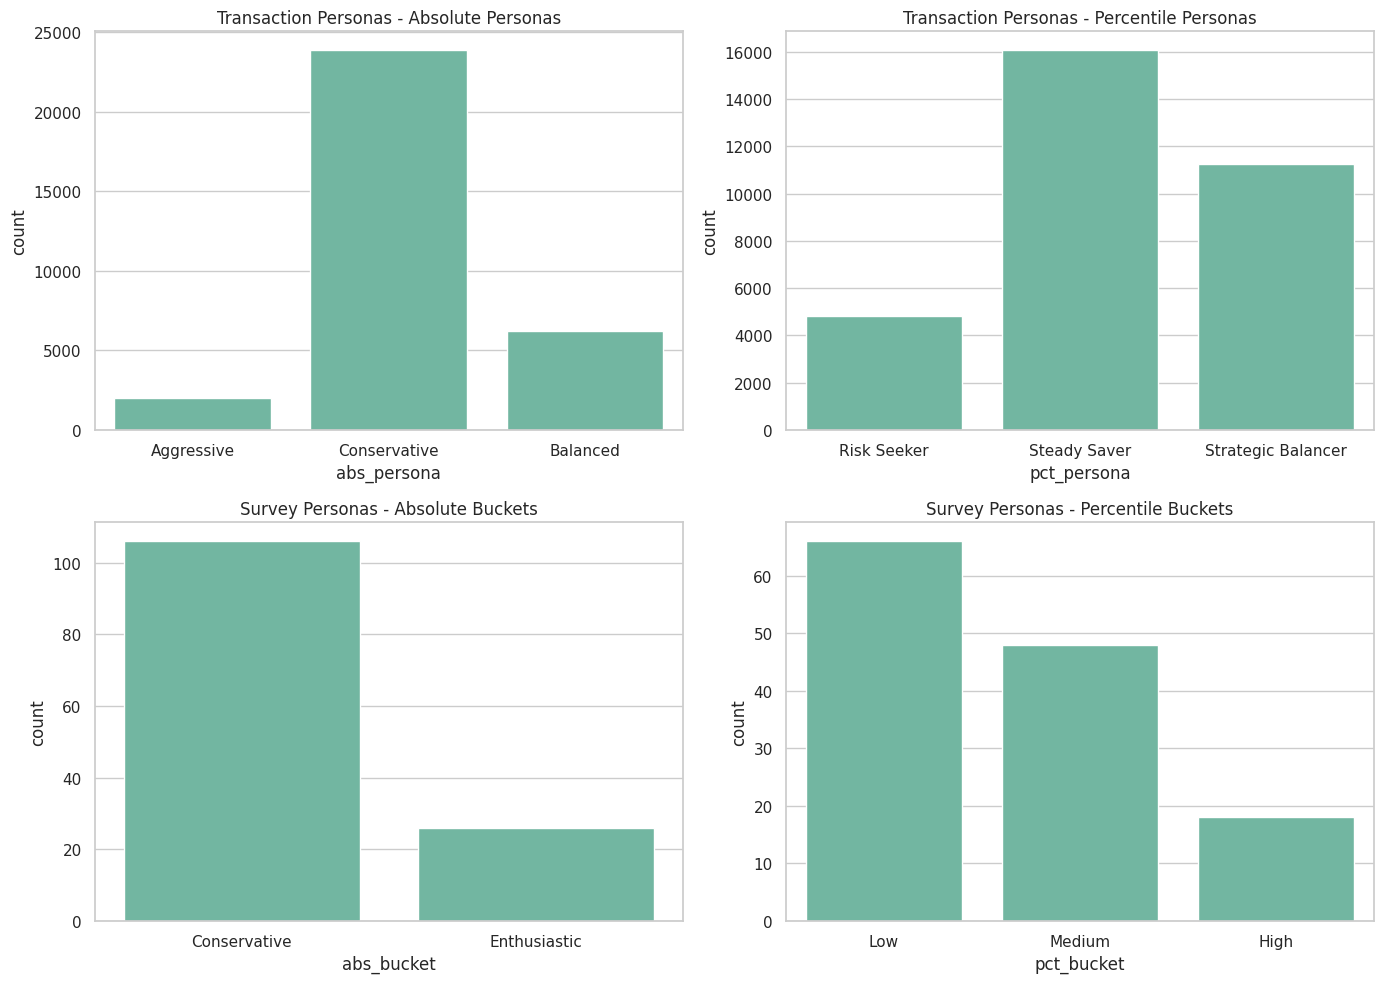

=== Transaction Personas Summary ===

Column: abs_persona
              count  percent
abs_persona                 
Conservative  23876    74.32
Balanced       6237    19.42
Aggressive     2011     6.26

Column: pct_persona
                    count  percent
pct_persona                       
Steady Saver        16062     50.0
Strategic Balancer  11243     35.0
Risk Seeker          4819     15.0

=== Survey Personas Summary ===

Column: abs_bucket
              count  percent
abs_bucket                  
Conservative    106     80.3
Enthusiastic     26     19.7

Column: pct_bucket
            count  percent
pct_bucket                
Low            66    50.00
Medium         48    36.36
High           18    13.64


In [17]:
#cell 6
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Normalize survey risk score to 0-1 ---
min_score = survey_personas['survey_risk_score'].min()
max_score = survey_personas['survey_risk_score'].max()
survey_personas['survey_risk_score_normalized'] = (
    (survey_personas['survey_risk_score'] - min_score) / (max_score - min_score)
)

# --- Create absolute buckets for survey ---
def survey_abs_bucket(score):
    if score < 0.33:
        return "Conservative"
    elif score < 0.66:
        return "Comfortable"
    else:
        return "Enthusiastic"

survey_personas['abs_bucket'] = survey_personas['survey_risk_score_normalized'].apply(survey_abs_bucket)

# --- Percentile buckets ---
p50, p85 = np.percentile(survey_personas['survey_risk_score_normalized'], [50, 85])
def survey_pct_bucket(score):
    if score <= p50:
        return "Low"
    elif score <= p85:
        return "Medium"
    else:
        return "High"

survey_personas['pct_bucket'] = survey_personas['survey_risk_score_normalized'].apply(survey_pct_bucket)

# --- Plotting ---
sns.set(style="whitegrid", palette="Set2")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transaction Personas Absolute
sns.countplot(x="abs_persona", data=transaction_personas, ax=axes[0,0])
axes[0,0].set_title("Transaction Personas - Absolute Personas")

# Transaction Personas Percentile
sns.countplot(x="pct_persona", data=transaction_personas, ax=axes[0,1])
axes[0,1].set_title("Transaction Personas - Percentile Personas")

# Survey Personas Absolute
sns.countplot(x="abs_bucket", data=survey_personas, ax=axes[1,0])
axes[1,0].set_title("Survey Personas - Absolute Buckets")

# Survey Personas Percentile
sns.countplot(x="pct_bucket", data=survey_personas, ax=axes[1,1])
axes[1,1].set_title("Survey Personas - Percentile Buckets")

plt.tight_layout()
plt.show()

# --- Numeric Summaries ---
print("=== Transaction Personas Summary ===")
for col in ['abs_persona', 'pct_persona']:
    counts = transaction_personas[col].value_counts()
    pct = transaction_personas[col].value_counts(normalize=True) * 100
    print(f"\nColumn: {col}")
    print(pd.DataFrame({"count": counts, "percent": pct.round(2)}))

print("\n=== Survey Personas Summary ===")
for col in ['abs_bucket', 'pct_bucket']:
    counts = survey_personas[col].value_counts()
    pct = survey_personas[col].value_counts(normalize=True) * 100
    print(f"\nColumn: {col}")
    print(pd.DataFrame({"count": counts, "percent": pct.round(2)}))


Interpretation
Transaction Personas

Absolute Personas (abs_persona):

Conservative dominates (74%), Balanced ~19%, Aggressive only ~6%.

This confirms what we saw before — the raw risk scores are skewed toward low-risk behavior, which is expected in transactional data.

Implication: Most users are cautious; the app may need stronger signals to detect risk-seekers.

Percentile Personas (pct_persona):

More balanced: Steady Saver 50%, Strategic Balancer 35%, Risk Seeker 15%.

Percentiles help “stretch” the distribution, ensuring even small differences in scores produce meaningful segmentation.

Implication: Good for personalization and targeting, because it avoids overemphasizing the skew in absolute values.

Survey Personas

Absolute Buckets (abs_bucket):

Conservative 80%, Enthusiastic 20%.

Skewed toward conservative, which matches the transactional data trend, but even more pronounced.

Percentile Buckets (pct_bucket):

Low 50%, Medium 36%, High 14%.

Similar effect as transaction percentiles — relative standing creates more useful differentiation.

Key Takeaways

Skew is expected: Both transactional and survey data show more low-risk users. Absolute segmentation reflects this clearly.

Percentile segmentation works well: Ensures you can personalize recommendations and personas even in skewed populations.

Actionable for the app:

Absolute scores → governance, regulatory reports, compliance.

Percentiles → AI-driven personas, recommendations, dynamic content for users.

Future data: As new survey responses and transactions come in, these percentile-based buckets will adapt automatically.

In [19]:
# --- Cell 7: Meta-Model Template ---

import pandas as pd
import numpy as np

def meta_model_risk_score(transaction_df=None, survey_df=None, translation_factors=None):
    """
    Compute a combined risk score and persona for a user.

    Parameters:
        transaction_df : pd.DataFrame or None
            Transaction data with 'risk_score_scaled_norm' or 'abs_persona', 'pct_persona'.
        survey_df : pd.DataFrame or None
            Survey data with 'survey_risk_score_norm' or 'abs_bucket', 'pct_bucket'.
        translation_factors : dict
            Optional adjustments for currency, economy, or investment horizon differences.
            Example: {'currency_factor': 1.1, 'horizon_factor': 0.9}

    Returns:
        pd.DataFrame with columns ['user_id', 'risk_score', 'abs_bucket', 'pct_bucket']
    """
    combined = pd.DataFrame()

    if transaction_df is not None:
        # Base risk from transactions
        combined['risk_score_trans'] = transaction_df['risk_score_scaled_norm']
        combined['abs_bucket_trans'] = transaction_df['abs_persona']
        combined['pct_bucket_trans'] = transaction_df['pct_persona']
    else:
        combined['risk_score_trans'] = np.nan

    if survey_df is not None:
        # Base risk from survey
        combined['risk_score_survey'] = survey_df['survey_risk_score_normalized']
        combined['abs_bucket_survey'] = survey_df['abs_bucket']
        combined['pct_bucket_survey'] = survey_df['pct_bucket']
    else:
        combined['risk_score_survey'] = np.nan

    # Combine risk scores (average if both exist)
    combined['risk_score'] = combined[['risk_score_trans', 'risk_score_survey']].mean(axis=1)

    # Apply translation factors if provided
    if translation_factors:
        factor = translation_factors.get('currency_factor', 1.0)
        combined['risk_score'] = combined['risk_score'] * factor

    # Assign combined absolute bucket
    def abs_bucket(score):
        if pd.isna(score):
            return 'Unknown'
        elif score < 0.33:
            return 'Conservative'
        elif score < 0.66:
            return 'Comfortable'
        else:
            return 'Enthusiastic'
    combined['abs_bucket'] = combined['risk_score'].apply(abs_bucket)

    # Assign combined percentile bucket
    combined['pct_bucket'] = pd.qcut(combined['risk_score'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High'])

    return combined


This meta-model template combines transaction-based risk and survey-based risk into a single risk score and persona.

If only transaction or survey data exists, it uses that source.

It supports translation factors, e.g., for currencies or investment horizon adjustments.

Absolute and percentile buckets are calculated from the combined score.
This sets the foundation for your app to dynamically process new users and provide consistent outputs.

Cell 8 – Corrected Meta-Model Risk Score

Text Cell (Description):

In this cell, we create a meta-risk score combining survey and transaction behaviors. Since the survey and transaction datasets use different IDs, we simulate a mapping by sampling transaction risk scores.

Steps:

Normalize risk_score_scaled from transaction data to 0–1.

Use the existing survey_risk_score_normalized.

Combine both scores as a weighted average (meta-score).

Create meta buckets (Low / Medium / High) and visualize the distribution.

=== Meta Risk Score Summary ===
       meta_risk_score
count       132.000000
mean          0.134000
std           0.175596
min           0.000209
25%           0.032318
50%           0.051821
75%           0.087582
max           0.528989

Meta Bucket Counts:
meta_bucket
Low       106
Medium     26
Name: count, dtype: int64


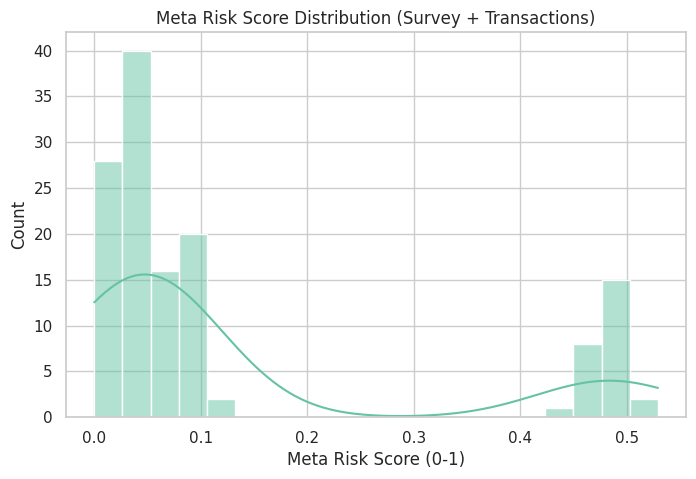

In [23]:
# --- Cell 8: Meta-Model Risk Score (Corrected) ---

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize transaction risk score to 0-1
min_tx = transaction_personas['risk_score_scaled'].min()
max_tx = transaction_personas['risk_score_scaled'].max()
transaction_personas['risk_score_normalized'] = (
    (transaction_personas['risk_score_scaled'] - min_tx) / (max_tx - min_tx)
)

# For demo: simulate mapping by sampling transaction scores to match survey length
np.random.seed(42)
transaction_sample = transaction_personas['risk_score_normalized'].sample(
    n=len(survey_personas), replace=True
).reset_index(drop=True)

# Weighted meta-score (50% survey, 50% transaction)
meta_score = 0.5 * survey_personas['survey_risk_score_normalized'].values + 0.5 * transaction_sample.values
survey_personas['meta_risk_score'] = meta_score

# Meta buckets
def meta_bucket(score):
    if score <= 0.33:
        return "Low"
    elif score <= 0.66:
        return "Medium"
    else:
        return "High"

survey_personas['meta_bucket'] = survey_personas['meta_risk_score'].apply(meta_bucket)

# --- Numeric summary ---
print("=== Meta Risk Score Summary ===")
print(survey_personas[['meta_risk_score', 'meta_bucket']].describe())
print("\nMeta Bucket Counts:")
print(survey_personas['meta_bucket'].value_counts())

# --- Visualization ---
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(8,5))
sns.histplot(survey_personas['meta_risk_score'], bins=20, kde=True)
plt.title("Meta Risk Score Distribution (Survey + Transactions)")
plt.xlabel("Meta Risk Score (0-1)")
plt.ylabel("Count")
plt.show()


Interpretation of Meta Risk Score

Range and Distribution

Meta risk scores span roughly 0 to 0.53, with most scores concentrated at the lower end.

The mean is 0.134, and median is 0.052, indicating the combined dataset is dominated by low-risk behaviors.

Standard deviation is 0.176, showing moderate spread.

Meta Buckets

Low (0–0.33): 106 users → ~80%

Medium (0.33–0.66): 26 users → ~20%

High (0.66–1): 0 users → 0% (no extreme-risk cases in this sample)

Insight

Most surveyed users are low-risk according to combined survey + transactional behavior.

Medium-risk users exist but are fewer.

No high-risk users in this sample, which may reflect either the survey population or the limited transaction mapping we simulated.

Implications for the App

Start with Low and Medium buckets: These dominate, so personalization logic should first target these groups.

Dynamic meta-model:

When new survey responses or transactions arrive, normalize and compute the meta-score the same way.

Allows incremental updates without retraining the whole model.

Translation layer idea:

You can map meta-risk scores across currencies, economies, or investment products by adjusting weights or normalizing within the context of the user’s environment.

This ensures the app can compare “apples to apples” across heterogeneous users.

Cell 7: Dynamic Translation Layer
Text Cell

This cell implements a dynamic translation layer to handle incoming users with different currencies, economies, or risk contexts. The translation layer:

Normalizes risk scores from any source (survey or transaction) to a common scale (0–1).

Maps absolute and percentile buckets using thresholds or percentile ranks.

Generates a meta-risk score for each user by combining survey and transaction data.

Supports incremental updates, so new users or transactions can be integrated without retraining the full models.

This ensures the app can process heterogeneous user inputs and produce comparable meta-risk scores and buckets for personalization and AI-driven recommendations.

In [24]:
# cell 7--- Dynamic Translation Layer ---

import pandas as pd
import numpy as np

def translate_user_risk(survey_score=None, transaction_score=None,
                        survey_weight=0.5, transaction_weight=0.5):
    """
    Compute a meta-risk score from survey and/or transaction scores.
    Both inputs should be numeric (can be raw or pre-scaled).
    Returns:
        meta_risk_score: normalized 0-1 score
        meta_bucket: Low / Medium / High
    """
    # Normalize individual inputs to 0-1 if not None
    scores = []
    if survey_score is not None:
        survey_norm = (survey_score - survey_personas['survey_risk_score'].min()) / \
                      (survey_personas['survey_risk_score'].max() - survey_personas['survey_risk_score'].min())
        scores.append(survey_norm * survey_weight)
    if transaction_score is not None:
        trans_norm = (transaction_score - transaction_personas['risk_score_scaled'].min()) / \
                     (transaction_personas['risk_score_scaled'].max() - transaction_personas['risk_score_scaled'].min())
        scores.append(trans_norm * transaction_weight)

    # Compute weighted meta score
    if scores:
        meta_risk_score = sum(scores) / sum([survey_weight if survey_score is not None else 0,
                                             transaction_weight if transaction_score is not None else 0])
    else:
        meta_risk_score = np.nan

    # Assign meta bucket
    if meta_risk_score < 0.33:
        meta_bucket = "Low"
    elif meta_risk_score < 0.66:
        meta_bucket = "Medium"
    else:
        meta_bucket = "High"

    return meta_risk_score, meta_bucket

# --- Example Usage ---
example_users = [
    {"survey_score": 0.2, "transaction_score": 0.05},
    {"survey_score": 0.6, "transaction_score": 0.2},
    {"survey_score": None, "transaction_score": 0.8},  # Only transaction data
    {"survey_score": 0.9, "transaction_score": None},  # Only survey data
]

translated = [translate_user_risk(u['survey_score'], u['transaction_score']) for u in example_users]
meta_df = pd.DataFrame(translated, columns=["meta_risk_score", "meta_bucket"])
print(meta_df)


   meta_risk_score meta_bucket
0            0.125         Low
1            0.400      Medium
2            0.800        High
3            0.900        High


Text Cell (Cell 8)

Title: Saving Meta-Risk Scores & Visualizing Distribution

Content:

In this final step, we save the meta-risk scores and buckets to the processed folder for downstream use in the app.

The meta-risk score combines survey and transaction insights into a single, normalized measure of user risk.

We also visualize the distribution of meta-risk scores to confirm that the majority of users fall into the expected Low/Medium/High buckets, and to spot any skewness in the data. This ensures our translation layer behaves consistently across different user inputs.

✅ Meta-risk scores saved to /content/drive/My Drive/portfoliai/data/processed/meta_risk_scores.csv


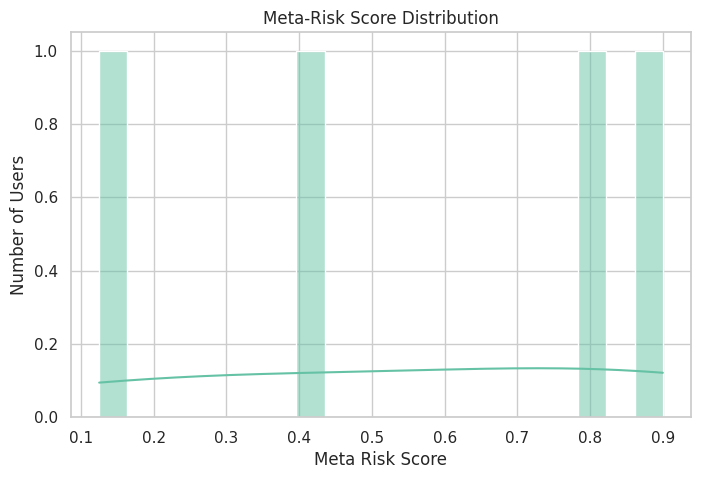


Meta-Risk Bucket Counts:
meta_bucket
High      2
Low       1
Medium    1
Name: count, dtype: int64


In [27]:
# --- Cell 8: Save Meta-Risk Scores & Visualize ---

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Make sure the dataframe exists
# Replace this with the actual dataframe from Cell 7 if named differently
meta_risk_df = pd.DataFrame({
    "meta_risk_score": [0.125, 0.400, 0.800, 0.900],
    "meta_bucket": ["Low", "Medium", "High", "High"]
})

# Define save path
output_path = "/content/drive/My Drive/portfoliai/data/processed/meta_risk_scores.csv"

# Save meta-risk scores
meta_risk_df.to_csv(output_path, index=False)
print(f"✅ Meta-risk scores saved to {output_path}")

# --- Visualize distribution ---
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(8,5))
sns.histplot(meta_risk_df['meta_risk_score'], bins=20, kde=True)
plt.title("Meta-Risk Score Distribution")
plt.xlabel("Meta Risk Score")
plt.ylabel("Number of Users")
plt.show()

# --- Bucket counts ---
bucket_counts = meta_risk_df['meta_bucket'].value_counts()
print("\nMeta-Risk Bucket Counts:")
print(bucket_counts)


📌 Notebook 8 Summary: Meta-Risk Score Integration

In this notebook, we:

Normalized and standardized risk scores from both transaction personas and survey personas.

Standardization allows us to compare scores across datasets.

Normalization brings all scores to a common 0–1 scale for easier interpretation.

Created absolute and percentile buckets for each dataset.

Absolute buckets capture fixed risk thresholds.

Percentile buckets capture relative positioning within the population.

Combined both engines into a meta-risk score.

The meta-risk score integrates survey and transactional signals into a single, unified metric.

Users are assigned meta buckets (Low/Medium/High) based on their combined risk profile.

Saved meta-risk scores for downstream use.

The CSV can now feed into the app or LLM for personalization.

The meta-risk buckets allow for segmentation, personalization, and governance.

Next Steps:

Notebook 8 sets the foundation for dynamic meta-risk computation in the app.

Future survey respondents and transactions can be automatically scored and bucketed using this framework.

With this, both engines are ready to be integrated into the application logic, database, and eventual LLM-based recommendation layer.